# 🧱 GANs on Bricks Data - Training

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the GAN](#build)
3. [Train the GAN](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, BatchNormalization, LeakyReLU, ReLU, UpSampling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import binary_crossentropy, BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean, BinaryAccuracy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import array_to_img

from utils.image import preprocess, display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1=0.5
ADAM_BETA_2=0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [4]:
train_data = image_dataset_from_directory(
    "/app/data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


2022-04-24 18:53:28.340315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 18:53:28.348610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 18:53:28.349230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 18:53:28.350443: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

train = train_data.map(lambda x: preprocess(x))

In [6]:
train_sample = sample_batch(train)

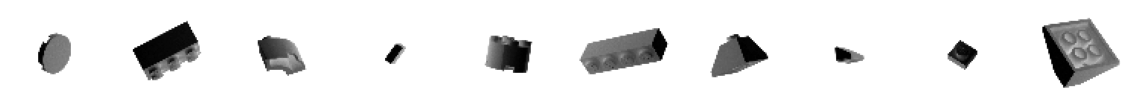

In [7]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [8]:
discriminator_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias = False)(discriminator_input)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum = 0.9)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias = False, activation = 'sigmoid')(x)
discriminator_output = Flatten()(x)

discriminator = Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                             

In [9]:
generator_input = Input(shape=(Z_DIM,))
x = Reshape((1, 1, Z_DIM))(generator_input)
x = Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias = False)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
generator_output = Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", use_bias = False, activation = 'tanh')(x)
generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [10]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.loss_fn = BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = Mean(name="d_loss")
        self.d_real_acc_metric = BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = BinaryAccuracy(name="d_acc")
        self.g_loss_metric = Mean(name="g_loss")
        self.g_acc_metric = BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.d_real_acc_metric, self.d_fake_acc_metric, self.d_acc_metric, self.g_loss_metric, self.g_acc_metric]
    
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            generated_images = self.generator(random_latent_vectors, training = True)
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(generated_images, training = True)
            
            real_labels = tf.ones_like(real_predictions) 
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(tf.shape(fake_predictions))
            
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            
            g_loss = self.loss_fn(real_labels, fake_predictions)
            
        
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state([real_labels, fake_labels], [real_predictions, fake_predictions])
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)
        
        return {m.name: m.result() for m in self.metrics}


In [11]:
#Create a GAN
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [ ]:
if LOAD_MODEL:
    gan.load_weights('./checkpoint/checkpoint.ckpt')

## 3. Train the GAN <a name="train"></a>

In [12]:
gan.compile(
    d_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2),
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2),
)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs")

class ImageGenerator(Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        


Epoch 165/300
313/313 [==============================] - ETA: 0s - d_loss: 0.3152 - d_real_acc: 0.9512 - d_fake_acc: 0.9488 - d_acc: 0.9500 - g_loss: 2.8738 - g_acc: 0.0512
Saved to ./output/generated_img_164.png


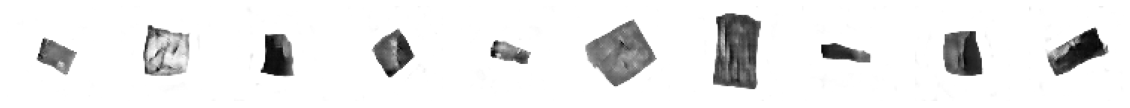

313/313 [==============================] - 48s 150ms/step - d_loss: 0.3152 - d_real_acc: 0.9512 - d_fake_acc: 0.9488 - d_acc: 0.9500 - g_loss: 2.8738 - g_acc: 0.0512
Epoch 166/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2520 - d_real_acc: 0.9880 - d_fake_acc: 0.9827 - d_acc: 0.9853 - g_loss: 2.8724 - g_acc: 0.0173
Saved to ./output/generated_img_165.png


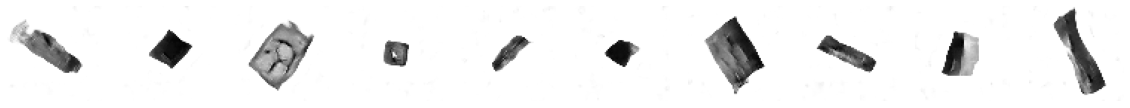

313/313 [==============================] - 47s 146ms/step - d_loss: 0.2520 - d_real_acc: 0.9880 - d_fake_acc: 0.9827 - d_acc: 0.9853 - g_loss: 2.8724 - g_acc: 0.0173
Epoch 167/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2356 - d_real_acc: 0.9943 - d_fake_acc: 0.9948 - d_acc: 0.9945 - g_loss: 3.0517 - g_acc: 0.0052
Saved to ./output/generated_img_166.png


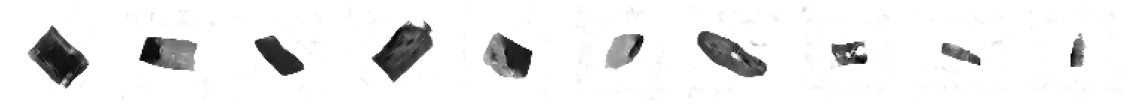

313/313 [==============================] - 47s 148ms/step - d_loss: 0.2356 - d_real_acc: 0.9943 - d_fake_acc: 0.9948 - d_acc: 0.9945 - g_loss: 3.0517 - g_acc: 0.0052
Epoch 168/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2409 - d_real_acc: 0.9933 - d_fake_acc: 0.9909 - d_acc: 0.9921 - g_loss: 3.0553 - g_acc: 0.0091
Saved to ./output/generated_img_167.png


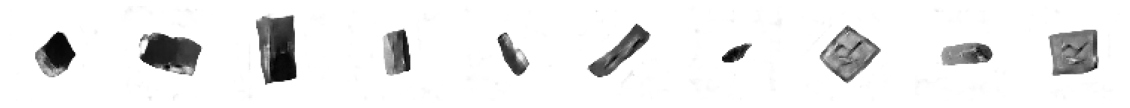

313/313 [==============================] - 47s 147ms/step - d_loss: 0.2409 - d_real_acc: 0.9933 - d_fake_acc: 0.9909 - d_acc: 0.9921 - g_loss: 3.0553 - g_acc: 0.0091
Epoch 169/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2576 - d_real_acc: 0.9792 - d_fake_acc: 0.9799 - d_acc: 0.9796 - g_loss: 2.9359 - g_acc: 0.0201
Saved to ./output/generated_img_168.png


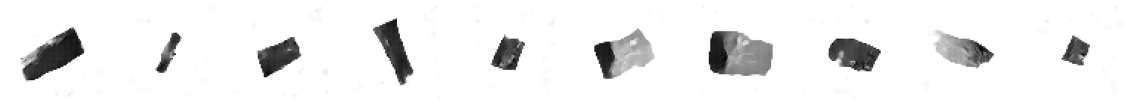

313/313 [==============================] - 47s 147ms/step - d_loss: 0.2576 - d_real_acc: 0.9792 - d_fake_acc: 0.9799 - d_acc: 0.9796 - g_loss: 2.9359 - g_acc: 0.0201
Epoch 170/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2513 - d_real_acc: 0.9869 - d_fake_acc: 0.9848 - d_acc: 0.9859 - g_loss: 2.9997 - g_acc: 0.0152
Saved to ./output/generated_img_169.png


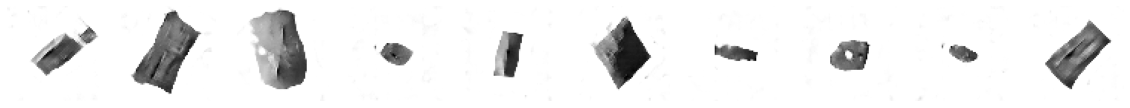

313/313 [==============================] - 47s 147ms/step - d_loss: 0.2513 - d_real_acc: 0.9869 - d_fake_acc: 0.9848 - d_acc: 0.9859 - g_loss: 2.9997 - g_acc: 0.0152
Epoch 171/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2392 - d_real_acc: 0.9948 - d_fake_acc: 0.9940 - d_acc: 0.9944 - g_loss: 3.0660 - g_acc: 0.0060
Saved to ./output/generated_img_170.png


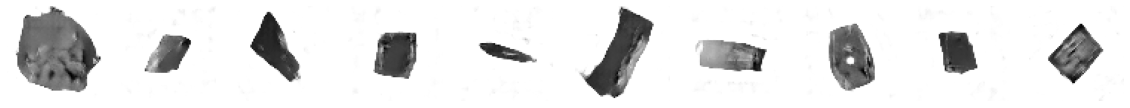

313/313 [==============================] - 47s 147ms/step - d_loss: 0.2392 - d_real_acc: 0.9948 - d_fake_acc: 0.9940 - d_acc: 0.9944 - g_loss: 3.0660 - g_acc: 0.0060
Epoch 172/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2397 - d_real_acc: 0.9943 - d_fake_acc: 0.9926 - d_acc: 0.9934 - g_loss: 3.0860 - g_acc: 0.0074
Saved to ./output/generated_img_171.png


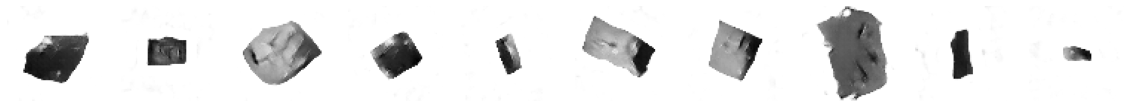

313/313 [==============================] - 47s 147ms/step - d_loss: 0.2397 - d_real_acc: 0.9943 - d_fake_acc: 0.9926 - d_acc: 0.9934 - g_loss: 3.0860 - g_acc: 0.0074
Epoch 173/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2508 - d_real_acc: 0.9857 - d_fake_acc: 0.9843 - d_acc: 0.9850 - g_loss: 3.0464 - g_acc: 0.0157
Saved to ./output/generated_img_172.png


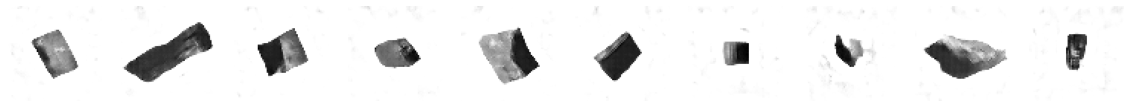

313/313 [==============================] - 47s 147ms/step - d_loss: 0.2508 - d_real_acc: 0.9857 - d_fake_acc: 0.9843 - d_acc: 0.9850 - g_loss: 3.0464 - g_acc: 0.0157
Epoch 174/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2817 - d_real_acc: 0.9625 - d_fake_acc: 0.9635 - d_acc: 0.9630 - g_loss: 2.8621 - g_acc: 0.0365
Saved to ./output/generated_img_173.png


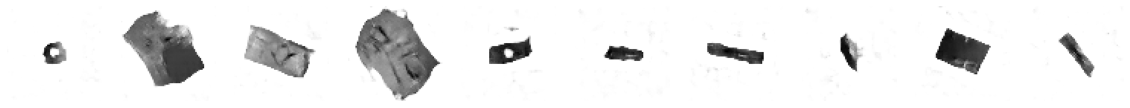

313/313 [==============================] - 47s 148ms/step - d_loss: 0.2817 - d_real_acc: 0.9625 - d_fake_acc: 0.9635 - d_acc: 0.9630 - g_loss: 2.8621 - g_acc: 0.0365
Epoch 175/300
313/313 [==============================] - ETA: 0s - d_loss: 0.2421 - d_real_acc: 0.9916 - d_fake_acc: 0.9925 - d_acc: 0.9921 - g_loss: 3.0180 - g_acc: 0.0075
Saved to ./output/generated_img_174.png


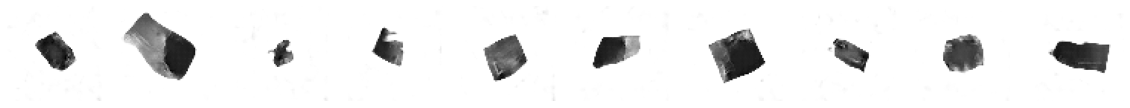

313/313 [==============================] - 47s 147ms/step - d_loss: 0.2421 - d_real_acc: 0.9916 - d_fake_acc: 0.9925 - d_acc: 0.9921 - g_loss: 3.0180 - g_acc: 0.0075
Epoch 176/300
159/313 [==============>...............] - ETA: 22s - d_loss: 0.2377 - d_real_acc: 0.9947 - d_fake_acc: 0.9944 - d_acc: 0.9945 - g_loss: 3.0748 - g_acc: 0.0056

KeyboardInterrupt: 

In [16]:
gan.fit(
    train, 
    epochs=EPOCHS, 
    # steps_per_epoch = 100, 
    initial_epoch = 164,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

In [17]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

2022-04-24 21:22:58.862810: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/generator/assets
INFO:tensorflow:Assets written to: ./models/discriminator/assets
